In [1]:
import numpy as np
import h5py
from sklearn.metrics import accuracy_score

In [1]:
def load_PD():
    with h5py.File('Parkinson-Augmented.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('x_train'))
        trainY = np.array(G1.get('y_train'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('x_test'))
        testY = np.array(G2.get('y_test'))

        return trainX, trainY, testX, testY

In [3]:
x_train, y_train, x_test, y_test = load_PD()
print(x_train.shape, y_train.shape, x_test.shape,y_test.shape)


(6314, 128, 128, 1) (6314,) (2706, 128, 128, 1) (2706,)


In [4]:
#make it ready for VGG16
x_train = np.repeat(x_train, 3, axis=3)
x_test = np.repeat(x_test, 3, axis=3)
print('x_train shape:', x_train.shape)

x_train shape: (6314, 128, 128, 3)


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
#VGG_model.summary()  # Trainable parameters will be 0

In [6]:
# Now, let us use features from convolutional network for KNN
print("extracting VGG16 features")
feature_extractor=VGG_model.predict(x_train)
print("reshaping features")
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
# print(feature_extractor.shape)
# print(features.shape)
X_Train = features #This is our X input to Logistic Regression.
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_Test = X_test_feature.reshape(X_test_feature.shape[0], -1)
print(X_Test.shape)
print(X_Train.shape)

extracting VGG16 features
reshaping features
(2706, 8192)
(6314, 8192)


In [7]:
print("model-1:KNN")
from sklearn.neighbors import KNeighborsClassifier
model1_KNN = KNeighborsClassifier(n_neighbors = 15, metric = 'minkowski', p = 2)

print('Train the model on training data')
model1_KNN.fit(X_Train, y_train) # For sklearn no one hot encoding

print("predicting")
# Now predict using the trained RF model.
prediction1 = model1_KNN.predict(X_Test)
print('KNN accuracy:', accuracy_score(y_test, prediction1))

model-1:KNN
Train the model on training data
predicting
KNN accuracy: 0.9933481152993349


In [8]:
print('model-2')
from sklearn import svm
model2_SVM = svm.SVC(kernel='linear',C=1, probability=True, random_state=42)
print('Train the model on training data')
model2_SVM.fit(X_Train,y_train)

print('predicting')
prediction2 = model2_SVM.predict(X_Test)
print('SVM accuracy:', accuracy_score(y_test, prediction2))

model-2
Train the model on training data
predicting
SVM accuracy: 0.9988913525498891


In [9]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('svm',model2_SVM),('knn',model1_KNN)], voting='soft')
model = model.fit(X_Train, y_train)

prediction = model.predict(X_Test)
print('Ensemble Accuracy:', accuracy_score(y_test,prediction))

Ensemble Accuracy: 0.999630450849963


In [19]:
#TODO: 
#the code for specificity, sensitivity, FPR, etc. 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
mcm = multilabel_confusion_matrix(y_true=y_test, y_pred=prediction, labels=[0,1], samplewise=False)
tn = mcm[:,0,0]
tp = mcm[:,1,1]
fp = mcm[:,0,1]
fn = mcm[:,1,0]
specificity = tn/(tn+fp)
print("Specificity or TNR",np.mean(specificity))

sensitivity = tp/(tp+fn)
print("Sensitivity or TPR or Recall",np.mean(sensitivity))

print("FNR ", 1-np.mean(sensitivity))

print("FPR", 1-np.mean(specificity))

print("Accuracy = ", metrics.accuracy_score(y_test, prediction))
# Confusion matrix
#FIXME:

Specificity or TNR 0.9996105919003115
Sensitivity or TPR or Recall 0.9996105919003115
FNR  0.0003894080996884597
FPR 0.0003894080996884597
Accuracy =  0.999630450849963


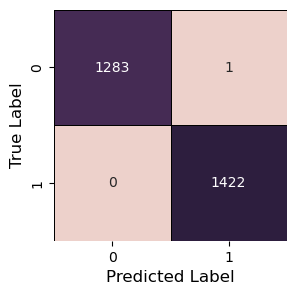

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, prediction)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3, 3))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), cbar=False, linewidth=0.5,linecolor="black",fmt='')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.savefig("CM_ensemble-PD.pdf")

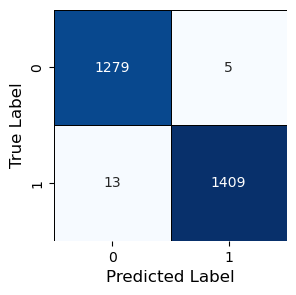

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, prediction1)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3, 3))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, linewidth=0.5,linecolor="black",fmt='')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.savefig("CM_KNN-PD.pdf")

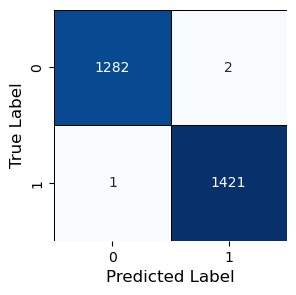

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, prediction2)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3, 3))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, linewidth=0.5,linecolor="black",fmt='')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.savefig("CM_SVM-PD.pdf")